In [ ]:
# See if we can't refactor these functions into one pre-processing function. 
# Compile into pipeline
# Add the feature of getting rid of names
# Work on creating more columns (see doc for list of columns to make)
# Columns: Sentences, noun phrases, keywords, etc.

In [2]:
import bs4

import matplotlib.pyplot as plt

import networkx as nx

import numpy as np

# For reading files
import os

# Data manipulation
import pandas as pd

# Text cleaning
import re

import requests

## Text processing
# NLP
import spacy
from spacy.lang.en import English
from spacy.matcher import Matcher
from spacy.tokens import Span
nlp = spacy.load("en_core_web_sm")

# Sentence boundary detection
import pysbd

# More NLP for fun
from textblob import TextBlob

from tqdm import tqdm

# Pipeline creation
from sklearn.pipeline import Pipeline

# Text extraction
from tika import parser

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [3]:
# Wanted to see details
pd.options.display.max_rows = 999

## Extracting Data from Resumes

In [76]:
# Construct dataframe
df = pd.DataFrame(columns=['all_text'])

In [77]:
all_text = []
filenames = []

def extract_data():
    for filename in os.listdir('Data/Raw_Data/'):
        file_data = parser.from_file('Data/Raw_Data/' + filename)
        text = file_data['content']
        filenames.append(filename)
        try:
            text = text.replace('\n', '')
            all_text.append(text)
        except:
            pass
#         print("extracting data from " + filename)
    df.all_text = all_text
    df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [78]:
extract_data()

In [122]:
df.head()

,all_text,sentences
0,0_KennyMcLeodResumeKenneth McLeod kennethkmcleodjr@gmail.com ❖ (718) 514-1871 WORK EXPERIENCE Tse-Systems China LTD. 2016 – Present Operations Manager ...,"[0_KennyMcLeodResumeKenneth McLeod kennethkmcleodjr@gmail.com ❖ (718) 514-1871 WORK EXPERIENCE Tse-Systems China LTD., 2016 – Present Operations Manager Remote ▪ Served a..."
1,"Ali Farhat_Cover LetterDear Hiring Manager, I am seeking the dynamic marketing position at your company. I'm a dedicated and organized marketer who highly values creativity, autonomy, communicatio...","[Ali Farhat_Cover LetterDear Hiring Manager, I am seeking the dynamic marketing position at your company., I'm a dedicated and organized marketer who highly values creativity, autonomy, communicat..."
2,"[LocalizedFileNames]\rMA_CoverLetter.pdf=@MA_CoverLetter.pdf,0\r","[[LocalizedFileNames], MA_CoverLetter.pdf=@MA_CoverLetter.pdf,0]"
3,"234 Pulaski St, Brooklyn, NY 11206, USA Brooklyn, NY, 11206 (718) 772-2732 jjasonworleyy@gmail.comJason Worley234 Pulaski St, Brooklyn, NY 11206, USA Brooklyn, NY, 11206(718) 772-2732j...","[234 Pulaski St, Brooklyn, NY 11206, USA Brooklyn, NY, 11206 (718) 772-2732 jjasonworleyy@gmail.comJason Worley234 Pulaski St, Brooklyn, NY 11206, USA Brooklyn, NY, 11206(718) 772-2732j..."
4,"J O A N N E S E P H I N E, AJ O A N N E S E P H I N E 500 East 77 Street, 1012 New York, NY 10162 917-797-9945 joanne@joannesephine.com May 2, 2019 Rewardyd New York, NY Re: Marketing ...","[J O A N N E S E P H I N E, AJ O A N N E S E P H I N E 500 East 77 Street, 1012 New York, NY 10162 917-797-9945 joanne@joannesephine.com May 2, 2019 Rewardyd New York, NY Re: Marketing..."


In [80]:
doc = df.all_text[0]

In [81]:
doc

"0_KennyMcLeodResumeKenneth McLeod kennethkmcleodjr@gmail.com ❖ (718) 514-1871 WORK EXPERIENCE  Tse-Systems China LTD.                         2016 – Present Operations Manager                          Remote ▪ Served as project manager for multiple projects, including developing and implementing technical training pro-grams and developing processes focused on client retention; analyzed relevant data to make business recom-mendations that resulted in market growth, quality and reliability improvements and contractor supply increases. ▪ Perform employee performance reviews and recommend appropriate salary changes; interview job applicants. ▪ Planned, scheduled and monitored transportation of  $5 million dollars worth of  equipment flawlessly without loss or damage. Stone-Mart                    2014 – 2016 Marketing Manager                  Tampa, FL ▪ Developed and launched integrated, multi-channel print, catalog, web and direct marketing campaigns that pro-pelled sales from $45M to a

### Extract list of sentences

<!--  Insert list of sentences into each cell  -->

In [6]:
df = pd.read_csv(r"C:\Users\sambe\Projects\Cover_Letter_Analysis\data\raw_data.csv", index_col=0)

In [7]:
df.head()

,username,title,raw_cover_letters,raw_resume
0,Abdul Albab,Accounts Payable Specialist,NaN,"Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347) 615-8170Work ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Accou..."
1,Abdul Shafaq,Accounts Payable Specialist,NaN,"Abdul Waheed Shafaq8581 N. Monroe Avenue, Lindenhurst, NY, 11757 | shafaqw2014@gmail.com | 347-335-8422Skills and Qualifications· Professional interpreter & translator; fluent in English, Dari, Pa..."
2,Abigail Riveron,Accounts Payable Specialist,"Dear Hiring Manager,I would like to express my deep interest in a position in your company.With my strong understanding of business and accounting principles gained throughout my education backgro...","CollegeGrad.com TemplateABIGAIL RIVERONMiami, FL 33177Mobile: 305.746.1662ariveron00@gmail.comProfessional SummaryEfficient, accurate and detail-oriented who takes initiative and has an innate dr..."
3,Abirami Suresh,Accounts Payable Specialist,NaN,"- Abirami Suresh.pagesAbirami Suresh 17 Bethel Lane, Schaumburg IL 60194 Mobile: 630-379-1405 Email: abisuresh62@gmail.com CAREER SUMMARY Highly self-motivated Senior Auditing Accountant with dem..."
4,Abria Bell,Training Manager,NaN,"Abria BellProject AdministratorChicago, IL 60617bellabria1213_2io@indeedemail.com7739700598#readytoworkWork ExperienceBilling / Administrative AssistantProject Org and Design Studio Inc - Chicago..."


In [17]:
def extract_sentences():
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = list(seg.segment(df.raw_cover_letters[0]))
    if sentences == ['']:
        pass
    df['cover_letter_sentences'][i] = sentences

In [19]:
df

,username,title,raw_cover_letters,raw_resume
0,Abdul Albab,Accounts Payable Specialist,NaN,"Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347) 615-8170Work ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Accou..."
1,Abdul Shafaq,Accounts Payable Specialist,NaN,"Abdul Waheed Shafaq8581 N. Monroe Avenue, Lindenhurst, NY, 11757 | shafaqw2014@gmail.com | 347-335-8422Skills and Qualifications· Professional interpreter & translator; fluent in English, Dari, Pa..."
2,Abigail Riveron,Accounts Payable Specialist,"Dear Hiring Manager,I would like to express my deep interest in a position in your company.With my strong understanding of business and accounting principles gained throughout my education backgro...","CollegeGrad.com TemplateABIGAIL RIVERONMiami, FL 33177Mobile: 305.746.1662ariveron00@gmail.comProfessional SummaryEfficient, accurate and detail-oriented who takes initiative and has an innate dr..."
3,Abirami Suresh,Accounts Payable Specialist,NaN,"- Abirami Suresh.pagesAbirami Suresh 17 Bethel Lane, Schaumburg IL 60194 Mobile: 630-379-1405 Email: abisuresh62@gmail.com CAREER SUMMARY Highly self-motivated Senior Auditing Accountant with dem..."
4,Abria Bell,Training Manager,NaN,"Abria BellProject AdministratorChicago, IL 60617bellabria1213_2io@indeedemail.com7739700598#readytoworkWork ExperienceBilling / Administrative AssistantProject Org and Design Studio Inc - Chicago..."
...,...,...,...,...
2120,Zichen Nie,Accounts Payable Specialist,NaN,"ZICHEN (CONSTANCE) NIEHacienda Heightsznie003@ucr.edu951-213-1736Professional Auditing, Systems, Managerial, Financial Statement Analysis, Fraud and Forensic Accounting, ITSkills..."
2121,Zihao Zhou,Accounts Payable Specialist,NaN,"Zihao ZhouManager / Business Development DirectorBoston, MALike challenging new tasks. Positive personality. Good at communication, experienced marketing andproducts specialist.Willing to relocat..."
2122,Zira Cortes,Training Manager,NaN,"Zira CortesSubstitute Teacher - SANDRIDGE Elementary SchoolChicago, IL 60633ziracortes9_rew@indeedemail.com(773)-704-4172I am seeking a full-time position where I can use my experience and educat..."
2123,Zoya Buyankina,Senior Account Manager,NaN,"ZOYA BUYANKINA SUMMARY: A young, self-motivated and achievement-oriented Business Development Analyst with more than 3 years of experience in the business development process and different marketi..."


In [29]:
sentences = []

def extract_sentences():
    i = 0
    sentences = []
    while i<len(df.raw_cover_letters):
        seg = pysbd.Segmenter(language="en", clean=False)
        sentences.append(seg)
#         sentences = list(seg.segment(df.raw_cover_letters[i]))
        if sentences == ['']:
            pass
#         df['cover_letter_sentences'][i] = sentences
        i += 1

In [30]:
extract_sentences()

In [31]:
sentences

[]

In [117]:
df['sentences'][1]

['Ali Farhat_Cover LetterDear Hiring Manager, I am seeking the dynamic marketing position at your company.',
 "I'm a dedicated and organized marketer who highly values creativity, autonomy, communication, as well as teamwork.",
 '2 years of experience in social media management revealed a passion for marketing, and introduced me to the fast-paced environment of a digital agency.',
 'Nonetheless, I decided to immerse myself in more marketing fields after working as an Account Management Intern in Summer 2017 at engageSimply.',
 'During my last position at Royale Marketing, I enjoyed building sustainable relationships and strategizing as a result of attending many client meetings (for brainstorming or following up), planning numerous events of various sizes, promoting them via several digital channels (social media, e-mail newsletters, social influencers, and event sites), and getting in touch with various vendors (event promoters, DJs, street team companies, modeling agencies, influence

In [100]:
df.head()

,all_text,sentences
0,0_KennyMcLeodResumeKenneth McLeod kennethkmcleodjr@gmail.com ❖ (718) 514-1871 WORK EXPERIENCE Tse-Systems China LTD. 2016 – Present Operations Manager ...,
1,"Ali Farhat_Cover LetterDear Hiring Manager, I am seeking the dynamic marketing position at your company. I'm a dedicated and organized marketer who highly values creativity, autonomy, communicatio...",
2,"[LocalizedFileNames]\rMA_CoverLetter.pdf=@MA_CoverLetter.pdf,0\r",
3,"234 Pulaski St, Brooklyn, NY 11206, USA Brooklyn, NY, 11206 (718) 772-2732 jjasonworleyy@gmail.comJason Worley234 Pulaski St, Brooklyn, NY 11206, USA Brooklyn, NY, 11206(718) 772-2732j...",
4,"J O A N N E S E P H I N E, AJ O A N N E S E P H I N E 500 East 77 Street, 1012 New York, NY 10162 917-797-9945 joanne@joannesephine.com May 2, 2019 Rewardyd New York, NY Re: Marketing ...",


In [48]:
doc = nlp(sentences[3])

for tok in doc:
    print(tok.text, "...", tok.dep_)

Nonetheless ... advmod
, ... punct
I ... nsubj
decided ... ROOT
to ... aux
immerse ... xcomp
myself ... dobj
in ... prep
more ... amod
marketing ... compound
fields ... pobj
after ... prep
working ... pcomp
as ... prep
an ... det
Account ... compound
Management ... compound
Intern ... pobj
in ... prep
Summer ... pobj
2017 ... nummod
at ... prep
engageSimply ... pobj
. ... punct


In [31]:
len(doc)

1934

In [18]:
def preprocessor(text):
    if type(text) == str:
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', ' ', text.lower())
    return text

In [19]:
doc = preprocessor(doc)

In [20]:
doc

'0_kennymcleodresumekenneth mcleod kennethkmcleodjr gmail com 718 514 1871 work experience tse systems china ltd 2016 present operations manager remote served as project manager for multiple projects including developing and implementing technical training pro grams and developing processes focused on client retention analyzed relevant data to make business recom mendations that resulted in market growth quality and reliability improvements and contractor supply increases perform employee performance reviews and recommend appropriate salary changes interview job applicants planned scheduled and monitored transportation of 5 million dollars worth of equipment flawlessly without loss or damage stone mart 2014 2016 marketing manager tampa fl developed and launched integrated multi channel print catalog web and direct marketing campaigns that pro pelled sales from 45m to a projected 50m by year end managed corporate marketing and communications functions overseeing a 400 000 budget and 8 m

In [21]:
print(seg.segment(doc))

['0_kennymcleodresumekenneth mcleod kennethkmcleodjr gmail com 718 514 1871 work experience tse systems china ltd 2016 present operations manager remote served as project manager for multiple projects including developing and implementing technical training pro grams and developing processes focused on client retention analyzed relevant data to make business recom mendations that resulted in market growth quality and reliability improvements and contractor supply increases perform employee performance reviews and recommend appropriate salary changes interview job applicants planned scheduled and monitored transportation of 5 million dollars worth of equipment flawlessly without loss or damage stone mart 2014 2016 marketing manager tampa fl developed and launched integrated multi channel print catalog web and direct marketing campaigns that pro pelled sales from 45m to a projected 50m by year end managed corporate marketing and communications functions overseeing a 400 000 budget and 8 

In [40]:
print('Original Article: %s' % (doc))
print()

for i, token in enumerate(doc.sents):
    print('-->Sentence %d: %s' % (i, token.text))

Original Article: 0_kennymcleodresumekenneth mcleod kennethkmcleodjr gmail com 718 514 1871 work experience tse systems china ltd 2016 present operations manager remote served as project manager for multiple projects including developing and implementing technical training pro grams and developing processes focused on client retention analyzed relevant data to make business recom mendations that resulted in market growth quality and reliability improvements and contractor supply increases perform employee performance reviews and recommend appropriate salary changes interview job applicants planned scheduled and monitored transportation of 5 million dollars worth of equipment flawlessly without loss or damage stone mart 2014 2016 marketing manager tampa fl developed and launched integrated multi channel print catalog web and direct marketing campaigns that pro pelled sales from 45m to a projected 50m by year end managed corporate marketing and communications functions overseeing a 400 0

AttributeError: 'str' object has no attribute 'sents'

In [34]:
# Tokenizes document
token_list = []
def spacy_tokenizer(text):
    nlp = English()
    tokenizer = nlp.Defaults.create_tokenizer(nlp)
    tokens = tokenizer(doc)
    for token in tokens:
        token_list.append(token.text)
    return token_list
spacy_tokenizer(doc)

['0_KennyMcLeodResumeKenneth',
 'McLeod',
 'kennethkmcleodjr@gmail.com',
 '❖',
 '(',
 '718',
 ')',
 '514',
 '-',
 '1871',
 'WORK',
 'EXPERIENCE',
 ' ',
 'Tse',
 '-',
 'Systems',
 'China',
 'LTD',
 '.',
 '                        ',
 '2016',
 '–',
 'Present',
 'Operations',
 'Manager',
 '                         ',
 'Remote',
 '▪',
 'Served',
 'as',
 'project',
 'manager',
 'for',
 'multiple',
 'projects',
 ',',
 'including',
 'developing',
 'and',
 'implementing',
 'technical',
 'training',
 'pro',
 '-',
 'grams',
 'and',
 'developing',
 'processes',
 'focused',
 'on',
 'client',
 'retention',
 ';',
 'analyzed',
 'relevant',
 'data',
 'to',
 'make',
 'business',
 'recom',
 '-',
 'mendations',
 'that',
 'resulted',
 'in',
 'market',
 'growth',
 ',',
 'quality',
 'and',
 'reliability',
 'improvements',
 'and',
 'contractor',
 'supply',
 'increases',
 '.',
 '▪',
 'Perform',
 'employee',
 'performance',
 'reviews',
 'and',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 ';',
 'intervi

In [35]:
len(token_list)

413

In [36]:
# Lemmatizes and removes stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
lemma_list = []
def spacy_lemmatizer(text):
    nlp = English()
    tokenizer = nlp.Defaults.create_tokenizer(nlp)
    tokens = tokenizer(text)
    for token in tokens:
        if token.is_stop is False:
            lemma_list.append(token.lemma_)
    return lemma_list
spacy_lemmatizer(doc)

['0_KennyMcLeodResumeKenneth',
 'McLeod',
 'kennethkmcleodjr@gmail.com',
 '❖',
 '(',
 '718',
 ')',
 '514',
 '-',
 '1871',
 'WORK',
 'EXPERIENCE',
 ' ',
 'Tse',
 '-',
 'Systems',
 'China',
 'LTD',
 '.',
 '                        ',
 '2016',
 '–',
 'Present',
 'Operations',
 'Manager',
 '                         ',
 'Remote',
 '▪',
 'Served',
 'project',
 'manager',
 'multiple',
 'projects',
 ',',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 '-',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 ';',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 '-',
 'mendations',
 'resulted',
 'market',
 'growth',
 ',',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 '.',
 '▪',
 'Perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 ';',
 'interview',
 'job',
 'applicants',
 '.',
 '▪',
 'Planned',
 ',',
 'scheduled',
 'monitored',
 'transp

In [37]:
len(lemma_list)

365

In [39]:
# Eliminates symbols. Use on lemma list!
import re
def preprocessor(text):
    if type(text) == str:
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
    return text
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)
tokens = tokenizer(doc)
lemma_list = []
for token in tokens:
    if token.is_stop is False:
        token_preprocessed = preprocessor(token.lemma_)
        if token_preprocessed != '':
             lemma_list.append(token_preprocessed)
preprocessor(lemma_list)

['0_kennymcleodresumekenneth',
 'mcleod',
 'kennethkmcleodjrgmailcom',
 '718',
 '514',
 '1871',
 'work',
 'experience',
 'tse',
 'systems',
 'china',
 'ltd',
 '2016',
 'present',
 'operations',
 'manager',
 'remote',
 'served',
 'project',
 'manager',
 'multiple',
 'projects',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 'mendations',
 'resulted',
 'market',
 'growth',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 'perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 'interview',
 'job',
 'applicants',
 'planned',
 'scheduled',
 'monitored',
 'transportation',
 '5',
 'million',
 'dollars',
 'worth',
 'equipment',
 'flawlessly',
 'loss',
 'damage',
 'stone',
 'mart',
 '2014',
 '2016',
 'marketing',
 'manager',
 'tampa',
 'fl',
 

In [40]:
len(lemma_list)

249

In [19]:
return_list = []
def preprocessor_final(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
        return text
    if isinstance((text), (list)):
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)
    else:
        pass

In [20]:
preprocessor_final(lemma_list)

['0_kennymcleodresumekenneth',
 'mcleod',
 'kennethkmcleodjrgmailcom',
 '718',
 '514',
 '1871',
 'work',
 'experience',
 'tse',
 'systems',
 'china',
 'ltd',
 '2016',
 'present',
 'operations',
 'manager',
 'remote',
 'served',
 'project',
 'manager',
 'multiple',
 'projects',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 'mendations',
 'resulted',
 'market',
 'growth',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 'perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 'interview',
 'job',
 'applicants',
 'planned',
 'scheduled',
 'monitored',
 'transportation',
 '5',
 'million',
 'dollars',
 'worth',
 'equipment',
 'flawlessly',
 'loss',
 'damage',
 'stone',
 'mart',
 '2014',
 '2016',
 'marketing',
 'manager',
 'tampa',
 'fl',
 

In [41]:
len(return_list)

249

In [48]:
# Removes numerical strings from list
def int_filter( someList ):
    for v in someList:
        try:
            int(v)
            continue # Skip these
        except ValueError:
            yield v # Keep these

lemma_list = list( int_filter( lemma_list ))


In [51]:
len(lemma_list)

233

In [59]:
return_list

['0_kennymcleodresumekenneth',
 'mcleod',
 'kennethkmcleodjrgmailcom',
 '718',
 '514',
 '1871',
 'work',
 'experience',
 'tse',
 'systems',
 'china',
 'ltd',
 '2016',
 'present',
 'operations',
 'manager',
 'remote',
 'served',
 'project',
 'manager',
 'multiple',
 'projects',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 'mendations',
 'resulted',
 'market',
 'growth',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 'perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 'interview',
 'job',
 'applicants',
 'planned',
 'scheduled',
 'monitored',
 'transportation',
 '5',
 'million',
 'dollars',
 'worth',
 'equipment',
 'flawlessly',
 'loss',
 'damage',
 'stone',
 'mart',
 '2014',
 '2016',
 'marketing',
 'manager',
 'tampa',
 'fl',
 

In [48]:
from sklearn.preprocessing import FunctionTransformer
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [54]:
spacy_estimators = [('tokenizer', pipelinize(spacy_tokenizer_lemmatizer)), ('preprocessor', pipelinize(preprocessor_final))]
spacy_pipe = Pipeline(spacy_estimators)
doc = spacy_pipe.transform([doc])

In [58]:
len(doc[0])

37419

In [ ]:
# Set up spaCy

parser = English()

# Test Data
multiSentence = "There is an art, it says, or rather, a knack to flying." \
                 "The knack lies in learning how to throw yourself at the ground and miss." \
                 "In the beginning the Universe was created. This has made a lot of people "\
                 "very angry and been widely regarded as a bad move."

In [ ]:
# all you have to do to parse text is this:
#note: the first time you run spaCy in a file it takes a little while to load up its modules
parsedData = parser(multiSentence)


In [24]:
# Let's look at the tokens
# All you have to do is iterate through the parsedData
# Each token is an object with lots of different properties
# A property with an underscore at the end returns the string representation
# while a property without the underscore returns an index (int) into spaCy's vocabulary
# The probability estimate is based on counts from a 3 billion word
# corpus, smoothed using the Simple Good-Turing method.
for i, token in enumerate(doc):
    print("original:", token.orth, token.orth_)
    print("lowercased:", token.lower, token.lower_)
    print("lemma:", token.lemma, token.lemma_)
    print("shape:", token.shape, token.shape_)
    print("prefix:", token.prefix, token.prefix_)
    print("suffix:", token.suffix, token.suffix_)
    print("log probability:", token.prob)
    print("Brown cluster id:", token.cluster)
    print("----------------------------------------")
    if i > 1:
        break

AttributeError: 'str' object has no attribute 'orth'

In [21]:

nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)
tokens = tokenizer(doc)
token_list = []
for token in tokens:
    token_list.append(token.text)
token_list

['0_KennyMcLeodResumeKenneth',
 'McLeod',
 'kennethkmcleodjr@gmail.com',
 '❖',
 '(',
 '718',
 ')',
 '514',
 '-',
 '1871',
 'WORK',
 'EXPERIENCE',
 ' ',
 'Tse',
 '-',
 'Systems',
 'China',
 'LTD',
 '.',
 '                        ',
 '2016',
 '–',
 'Present',
 'Operations',
 'Manager',
 '                         ',
 'Remote',
 '▪',
 'Served',
 'as',
 'project',
 'manager',
 'for',
 'multiple',
 'projects',
 ',',
 'including',
 'developing',
 'and',
 'implementing',
 'technical',
 'training',
 'pro',
 '-',
 'grams',
 'and',
 'developing',
 'processes',
 'focused',
 'on',
 'client',
 'retention',
 ';',
 'analyzed',
 'relevant',
 'data',
 'to',
 'make',
 'business',
 'recom',
 '-',
 'mendations',
 'that',
 'resulted',
 'in',
 'market',
 'growth',
 ',',
 'quality',
 'and',
 'reliability',
 'improvements',
 'and',
 'contractor',
 'supply',
 'increases',
 '.',
 '▪',
 'Perform',
 'employee',
 'performance',
 'reviews',
 'and',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 ';',
 'intervi

In [6]:
text.tags

[('Ebony', 'NNP'),
 ('Moore', 'NNP'),
 ('123', 'CD'),
 ('456-7891', 'CD'),
 ('emoore', 'NN'),
 ('@', 'NNP'),
 ('email.com', 'NN'),
 ('May', 'NNP'),
 ('1', 'CD'),
 ('2018', 'CD'),
 ('Dear', 'NNP'),
 ('Hiring', 'NNP'),
 ('Manager', 'NNP'),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('excited', 'JJ'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('applying', 'VBG'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('Data', 'NNP'),
 ('Analyst', 'NNP'),
 ('position', 'NN'),
 ('at', 'IN'),
 ('Cloud', 'NNP'),
 ('Clearwater', 'NNP'),
 ('As', 'IN'),
 ('someone', 'NN'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('lifetime', 'JJ'),
 ('love', 'NN'),
 ('of', 'IN'),
 ('relational', 'JJ'),
 ('mathematics', 'NNS'),
 ('and', 'CC'),
 ('pattern', 'JJ'),
 ('recognition', 'NN'),
 ('I', 'PRP'),
 ('thrive', 'VBP'),
 ('on', 'IN'),
 ('digging', 'VBG'),
 ('into', 'IN'),
 ('complex', 'JJ'),
 ('data', 'NNS'),
 ('sets', 'NNS'),
 ('and', 'CC'),
 ('producing', 'VBG'),
 ('insightful', 'JJ'),
 ('data-driven', 'JJ'),
 ('strategic', 'JJ'),
 ('recommendations', 'NNS'),
 

In [109]:
phrases = text.noun_phrases

NameError: name 'text' is not defined

In [55]:
print(phrases)

['kenneth mcleod', 'kennethkmcleodjr @ gmail.com ❖', 'work experience tse-systems china ltd.', 'present operations', 'remote', 'served', 'project manager', 'multiple projects', 'technical training pro- grams', 'client retention', 'relevant data', 'business recom- mendations', 'market growth', 'reliability improvements', 'perform', 'employee performance reviews', 'appropriate salary changes', 'interview job applicants', 'planned', 'dollars worth', 'stone-mart', 'tampa', 'fl', 'developed', 'multi-channel print', '$ 45m', '$ 50m', 'managed', 'communications functions', '8-member team', 'direct', 'brand management', 'pr', 'media relations', 'product launches', 'sales col- lateral', 'ami', 'content', 'tampa', 'fl', 'articulate client companies', 'value proposition', 'brand architecture', 'creating', 'content audience', 'yale', 'coordinator', 'haven', 'ct', 'coordinated', 'site', 'business manager', 'haven', 'ct', 'managed', 'oversaw', 'administrative budget', 'expense reports', 'bank reconc

In [56]:
phrases_list = []
for phrase in phrases:
    phrases_list.append(phrase)

In [57]:
b = [len(list(group)) for key, group in groupby(phrases)]

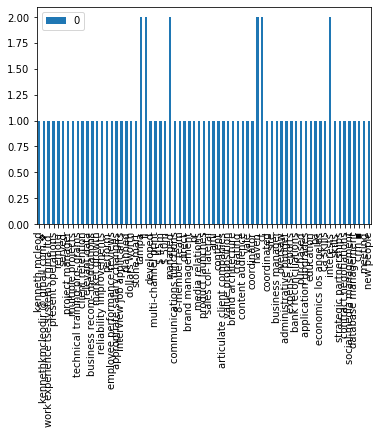

In [58]:
import pandas
from collections import Counter
letter_counts = Counter(phrases)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

In [59]:
from itertools import dropwhile

for key, count in dropwhile(lambda key_count: key_count[1] >= 2, letter_counts.most_common()):
    del letter_counts[key]

In [60]:
letter_counts

Counter({'tampa': 2,
         'fl': 2,
         'managed': 2,
         'haven': 2,
         'ct': 2,
         'interests': 2})